# Л.р. №1: метрические алгоритмы классификации

In [778]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.base import BaseEstimator

---

## Часть 1. Изучение данных

In [791]:
data = pd.read_csv('chips.txt', header=None, names=['X', 'Y', 'Class'])

In [792]:
data.head()

,X,Y,Class
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [793]:
data.describe()

,X,Y,Class
count,118.000000,118.000000,118.000000
mean,0.054779,0.183102,0.491525
std,0.496654,0.519743,0.502060
min,-0.830070,-0.769740,0.000000
25%,-0.372120,-0.254385,0.000000
50%,-0.006336,0.213455,0.000000
75%,0.478970,0.646562,1.000000
max,1.070900,1.108900,1.000000


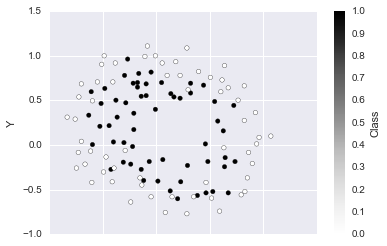

In [794]:
data.plot(kind='scatter', x='X', y='Y', c='Class')

## Часть 2. Feature Engineering

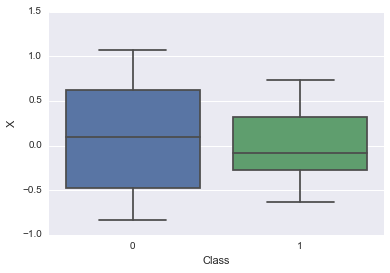

In [795]:
sns.boxplot(data=data, x="Class", y="X")

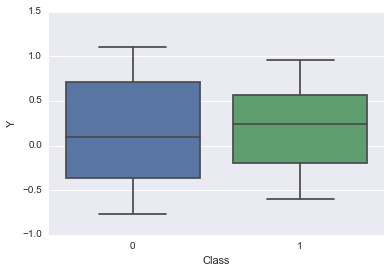

In [796]:
sns.boxplot(data=data, x="Class", y="Y")

In [797]:
data['Z1'] = abs(data['X'] - data['X'].mean()) + abs(data['Y'] - data['Y'].mean())
data['Z2'] = ((data['X'] - data['X'].mean())**2 + (data['Y'] - data['Y'].mean())**2) ** 0.5

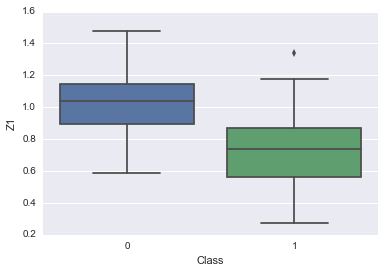

In [798]:
sns.boxplot(data=data, x="Class", y="Z1")

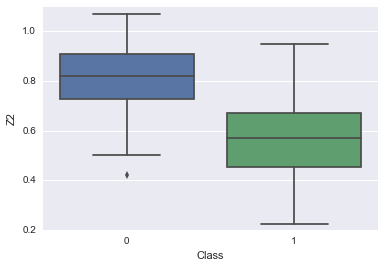

In [799]:
sns.boxplot(data=data, x="Class", y="Z2")

Видим, что по обоим параметрам Z1 и Z2 классы получились неплохо разделимы. Значит добавление этих признаков в выборку имеет смысл и скорее всего увеличит предсказательную силу модели.

## Часть 3. Описание модели

In [800]:
# TODO: It would be a nice idea to implement KNNClassifier
# TODO: using k-d trees.

def euclidean_metric(x, y):
    return np.linalg.norm(x - y, 2)

def manhattan_metric(x, y):
    return np.linalg.norm(x - y, 1)

class KNNClassifier(BaseEstimator):
    def __init__(self, k=1, metric=euclidean_metric):
        self.k = k
        self.metric = metric

    def get_params(self, deep=False):
        return {"k": self.k,
                "metric": self.metric}

    def set_params(self, **params):
        self.k = params["k"]
        self.metric = params["metric"]
    
    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X):
        ys = []
        for x in X:
            order = np.apply_along_axis(lambda y: self.metric(x, y), 1, self.X)
            index = np.argsort(order)
            self.y = self.y[index]
            ws = Counter()
            for ix, v in enumerate(self.y[:self.k]):
                # linearly decreasing weights
                w = self.k - ix
                ws[v] = ws.get(v, 0) + w
            ys.append(ws.most_common(1)[0][0])
        return np.asarray(ys)
    
    def score(self, X, y, score="accuracy"):
        y_pred = self.predict(X)
        if score == "accuracy":
            return accuracy_score(y, y_pred)
        elif score == "f1":
            return f1_score(y, y_pred)
        else:
            raise RuntimeError("unknown score")

In [801]:
X = data[['X', 'Y', 'Z1', 'Z2']].values
y = data['Class'].values

#### Отнормируем признаки, чтобы упростить будущей метрике жизнь
**NB**: это также равносильно тому, чтобы использовать метрику с весами при признаках.

In [802]:
X = normalize(X)

---

## Часть 4. Обучение и кросс-валидация модели

In [772]:
X_learn, X_holdout, y_learn, y_holdout = train_test_split(X, y, test_size=0.25, random_state=1)
X_train, X_test, y_train, y_test       = train_test_split(X_learn, y_learn, test_size=0.33, random_state=1)

In [803]:
print("Learn size: %d" % X_learn.shape[0])
print("  Train size: %d" % X_train.shape[0])
print("  Test size: %d" % X_test.shape[0])
print("Hold-out size: %d" % X_holdout.shape[0])

Learn size: 88
  Train size: 58
  Test size: 30
Hold-out size: 30


### Сначала без кросс-валидации, заодно подберём оптимальный K и посмотрим на разные метрики

In [805]:
Ks = np.arange(1, 50, 1)

CPU times: user 2.48 s, sys: 25 ms, total: 2.5 s
Wall time: 2.54 s


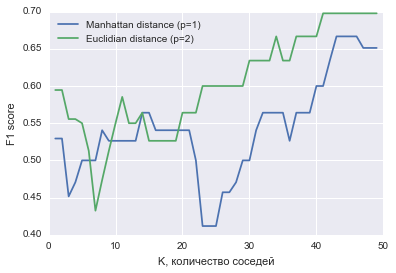

In [806]:
%%time

scores_1 = []
scores_2 = []

for K in Ks:
    knn_1 = KNNClassifier(K, metric=manhattan_metric)
    knn_2 = KNNClassifier(K, metric=euclidean_metric)
    knn_1.fit(X_train, y_train)
    knn_2.fit(X_train, y_train)
    scores_1.append(knn_1.score(X_test, y_test, "f1"))
    scores_2.append(knn_2.score(X_test, y_test, "f1"))

plt.xlabel("K, количество соседей")
plt.ylabel("F1 score")
plt.plot(Ks, scores_1, label='Manhattan distance (p=1)')
plt.plot(Ks, scores_2, label='Euclidian distance (p=2)')
plt.legend(loc=0)

### Теперь то же самое с кросс-валидацией

CPU times: user 30.2 s, sys: 4.77 s, total: 34.9 s
Wall time: 45.1 s


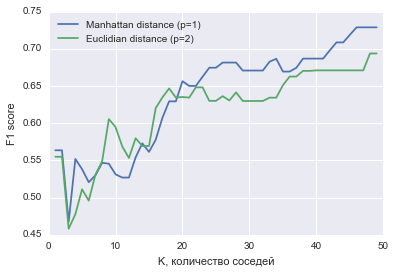

In [809]:
%%time

scores_1 = []
scores_2 = []

for K in Ks:
    cv_score_1 = cross_val_score(KNNClassifier(K, metric=manhattan_metric), X_learn, y_learn, scoring="f1", cv=5, n_jobs=-1)
    cv_score_2 = cross_val_score(KNNClassifier(K, metric=euclidean_metric), X_learn, y_learn, scoring="f1", cv=5, n_jobs=-1)
    scores_1.append(np.mean(cv_score_1))
    scores_2.append(np.mean(cv_score_2))

plt.xlabel("K, количество соседей")
plt.ylabel("F1 score")
plt.plot(Ks, scores_1, label='Manhattan distance (p=1)')
plt.plot(Ks, scores_2, label='Euclidian distance (p=2)')
plt.legend(loc=0)

---

## Часть 5. Использование модели

### Посмотрим на обученный kNN-классификатор при каком-то K

In [777]:
K = 7
knn = KNNClassifier(K)
knn.fit(X_learn, y_learn)
print("Hold-out score (K=%d): %.2f" % (K, knn.score(X_holdout, y_holdout, "f1")))

Hold-out score (K=7): 0.40
